# GAN 对抗生成网络基础

[参考文档  https://zhuanlan.zhihu.com/p/43047326](https://zhuanlan.zhihu.com/p/43047326)

[代码地址](https://github.com/aadilh/blogs/tree/new/basic-gans/basic-gans)

In [1]:
# -*- coding: UTF-8 -*-
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sb
sb.set()
print(tf.__version__)

1.5.0


### 生成数据

In [2]:
BASE_DIR = '/home/ec2-user/tutorials/machine-learning/stepbystep/'
def get_y(x):
    return 10 + x*x

#真实数据
def sample_data(n=1000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

# 获取随机数据
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

### 生成网络 和鉴别网络

In [3]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

In [4]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

# 先用Z生成随机样本
G_sample = generator(Z)

# 用真实数据进行学习
r_logits, r_rep = discriminator(X)

# 用学习到的参数 进行鉴别
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) 
                           + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step



# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 128
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open(BASE_DIR+'output/loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(3001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))
        print("Iterations: %6d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        
    if i%600 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig(BASE_DIR+'output/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig(BASE_DIR+'output/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig(BASE_DIR+'output/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

Iterations:      0	 Discriminator loss: 0.6713	 Generator loss: 0.7239
Iterations:     10	 Discriminator loss: 0.3376	 Generator loss: 1.2301
Iterations:     20	 Discriminator loss: 0.0311	 Generator loss: 3.5122
Iterations:     30	 Discriminator loss: 0.0009	 Generator loss: 7.1234
Iterations:     40	 Discriminator loss: 0.0010	 Generator loss: 11.1977
Iterations:     50	 Discriminator loss: 0.1041	 Generator loss: 11.2324
Iterations:     60	 Discriminator loss: 0.4424	 Generator loss: 7.7654
Iterations:     70	 Discriminator loss: 0.5526	 Generator loss: 4.1368
Iterations:     80	 Discriminator loss: 0.5571	 Generator loss: 3.5431
Iterations:     90	 Discriminator loss: 0.6331	 Generator loss: 3.3038
Iterations:    100	 Discriminator loss: 2.6997	 Generator loss: 1.3818
Iterations:    110	 Discriminator loss: 3.8583	 Generator loss: 1.0076
Iterations:    120	 Discriminator loss: 5.4026	 Generator loss: 0.6377
Iterations:    130	 Discriminator loss: 0.8813	 Generator loss: 1.4402
Iter

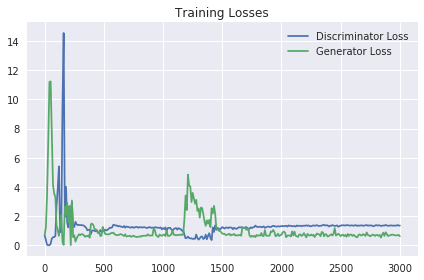

In [5]:
data = pd.read_csv(BASE_DIR+'output/loss_logs.csv')

plt.plot('Iteration','Discriminator Loss',data=data)
plt.plot('Iteration','Generator Loss',data=data)

plt.legend()
plt.title('Training Losses')
plt.tight_layout()
# plt.savefig('../plots/dataset.png')
plt.savefig(BASE_DIR+'output/training_loss.png')
plt.show()